<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/images-skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skeleton for Images

* you need to end up having at least a subset of all images in a numpy array
* this code will do this by loading images from disk and label them according to the folder they are in

In [1]:
import pandas as pd
print(pd.__version__)

0.25.1


In [2]:
import numpy as np
print(np.__version__)

1.17.1


In [3]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/speed-limit-signs.zip
!unzip -qo speed-limit-signs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  4 1795k    4 81086    0     0  81086      0  0:00:22 --:--:--  0:00:22  561k
100 1795k  100 1795k    0     0  1795k      0  0:00:01 --:--:--  0:00:01 4788k


In [4]:
# !ls -lR speed-limit-signs
!ls -l speed-limit-signs

total 69
drwxr-xr-x 1 olive 197609   0 Aug 31 08:42 0
drwxr-xr-x 1 olive 197609   0 Aug 31 08:42 1
drwxr-xr-x 1 olive 197609   0 Aug 31 08:42 2
drwxr-xr-x 1 olive 197609   0 Aug 31 08:42 3
drwxr-xr-x 1 olive 197609   0 Aug 31 08:42 4
drwxr-xr-x 1 olive 197609   0 Aug 31 08:42 5
-rw-r--r-- 1 olive 197609 407 Aug 28 18:08 README.md


In [5]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120


In [6]:
import os
import skimage.data

ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
type = ".ppm"

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d))]
# Loop through the label directories and collect the data in
# two lists, labels and images.
labels = []
images = []
for d in directories:
    label_dir = os.path.join(data_dir, d)
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for f in file_names:
        images.append(skimage.data.imread(f))
        labels.append(int(d))

images, labels = np.array(images), np.array(labels)

In [7]:
images.shape

(379,)

In [8]:
labels.shape

(379,)

In [9]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([79, 81, 68, 53, 41, 57], dtype=int64))

### First image for each Label

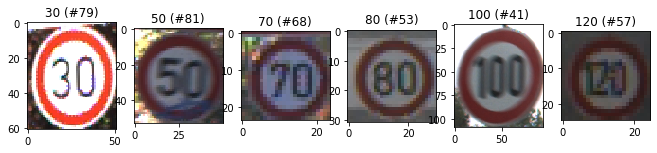

In [11]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 15))

unique_values, counts = np.unique(labels, return_counts=True)
classes = len(unique_values)
label_names = ['30', '50', '70', '80', '100', '120']

i = 1
for label in unique_values:
    # Pick the first image for each label.
    image = images[np.where(labels == label)[0][0]]
    plt.subplot(1, 8, i)
    plt.title("{0} (#{1})".format(label_names[label], counts[label]))
    i += 1
    plt.imshow(image)

### Ooops, different resolutions (as you can see from the axes)

We need to have all of them with the same resolution

In [12]:
import skimage.transform

images_32 = np.array([skimage.transform.resize(image, (32, 32)) for image in images])

In [13]:
# 379 samples, 32x32 resoltion, 3 color channels
images_32.shape

(379, 32, 32, 3)

## Just for the fun of it: let us try a very simple model on that

In [14]:
X = images_32
y = labels

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((303, 32, 32, 3), (76, 32, 32, 3), (303,), (76,))

In [16]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

In [17]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc0


In [18]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

model = tf.keras.Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0

In [19]:
# this is no fun CPU, on a weak i5 this takes 10 minutes
%%time

BATCH_SIZE=50
EPOCHS = 500

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=0)

Wall time: 9min 48s


In [21]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.020072310163731354, 0.9966997)

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(1.1213236827599375, 0.8815789)

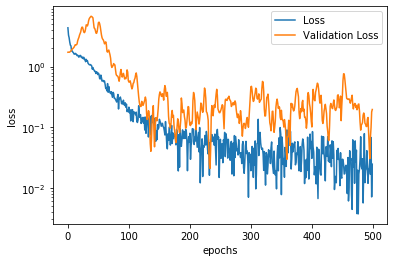

In [23]:
plt.xlabel('epochs')
plt.ylabel('loss')

plt.yscale('log')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

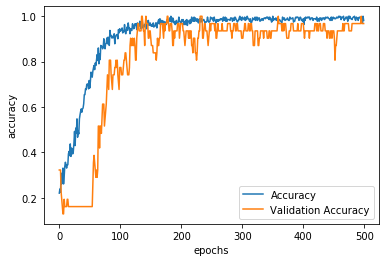

In [24]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy'])

In [25]:
y_pred = model.predict(X).argmax(axis=1)

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred)
cm

array([[74,  1,  1,  3,  0,  0],
       [ 0, 79,  0,  2,  0,  0],
       [ 0,  0, 68,  0,  0,  0],
       [ 0,  0,  0, 53,  0,  0],
       [ 0,  0,  1,  1, 39,  0],
       [ 0,  0,  0,  0,  1, 56]], dtype=int64)

In [27]:
import seaborn as sns

figure = plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)

ModuleNotFoundError: No module named 'seaborn'

### Trying samples exclusively from the test set

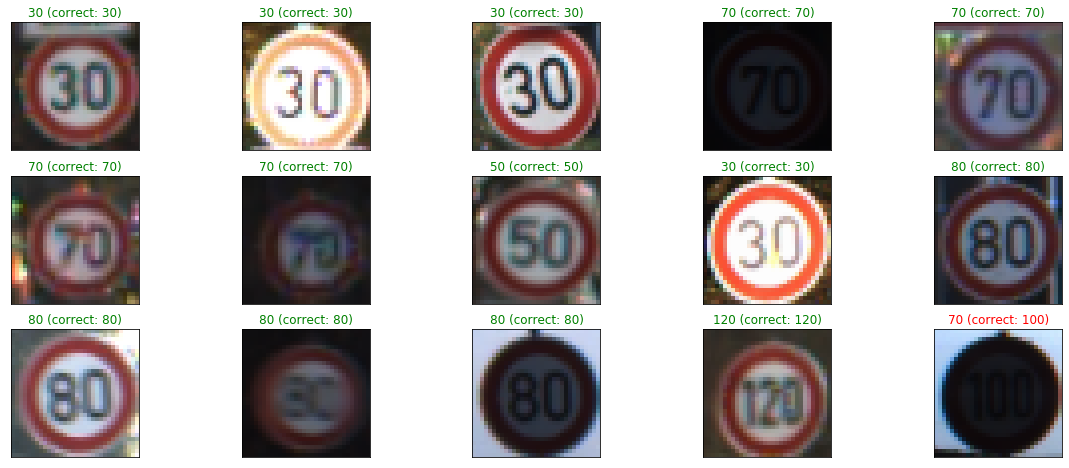

In [28]:
y_pred_test = model.predict(X_test).argmax(axis=1)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = y_pred_test[index]
    true_index = y_test[index]
    # Set the title for each image
    ax.set_title("{} (correct: {})".format(label_names[predict_index], 
                                  label_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [29]:
model.save('speed-signs-simple.h5')

## Alternative: Standard Architectures like ResNet (or Mobilenet to save training time) 
* basic ideas
  * depth does matter
  * 8x deeper than VGG
  * possible by using shortcuts and skipping final fc layer
  * prevents vanishing gradient problem
* https://keras.io/applications/#resnet50
* https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba

http://arxiv.org/abs/1512.03385
![Deep Learning](https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/residual.png)

In [67]:
from tensorflow.keras.applications.resnet50 import ResNet50

# https://keras.io/applications/#mobilenet
# https://arxiv.org/pdf/1704.04861.pdf
from tensorflow.keras.applications.mobilenet import MobileNet

# might take forever to train, so we might prefer mobile net
# model = ResNet50(classes=classes, weights=None, input_shape=(32, 32, 3))

model = MobileNet(classes=classes, weights=None, input_shape=(32, 32, 3))

model.summary()

Model: "mobilenet_1.00_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)  

In [76]:
  %%time

# can not go higher for reset, already over 8GB of GPU memory
# BATCH_SIZE=10

BATCH_SIZE=50
EPOCHS = 1000

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=0)

CPU times: user 12.7 s, sys: 1.25 s, total: 14 s
Wall time: 13.9 s


In [77]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.30405994850641543, 0.97029704)

In [78]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(2.6775264300798116, 0.75)

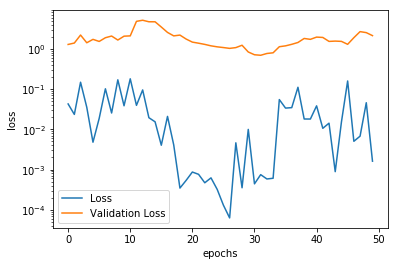

In [79]:
plt.xlabel('epochs')
plt.ylabel('loss')

plt.yscale('log')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

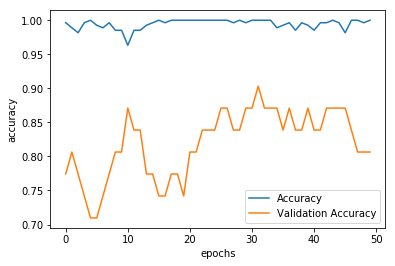

In [80]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy'])

In [0]:
y_pred = model.predict(X).argmax(axis=1)

In [82]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred)
cm

array([[70,  5,  2,  1,  1,  0],
       [ 0, 78,  1,  2,  0,  0],
       [ 3,  4, 61,  0,  0,  0],
       [ 1,  3,  0, 47,  1,  1],
       [ 0,  0,  0,  0, 41,  0],
       [ 0,  0,  2,  1,  0, 54]])

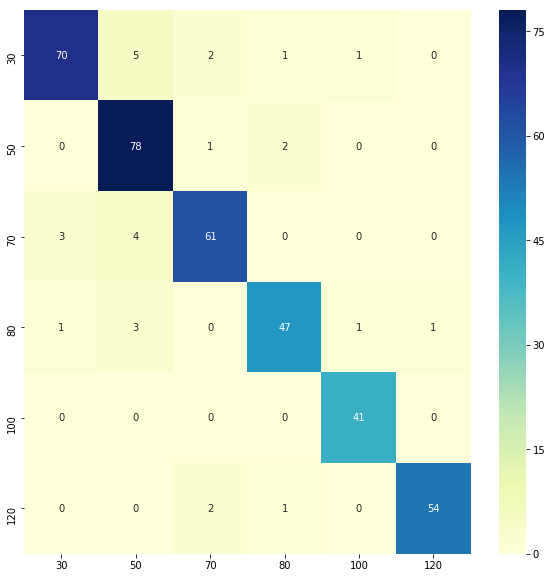

In [83]:
import seaborn as sns

figure = plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)

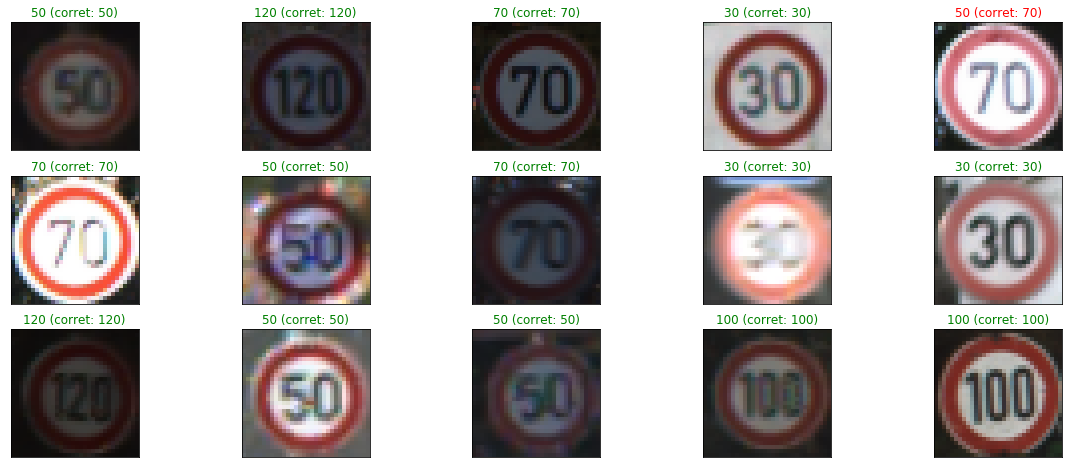

In [84]:
y_pred_test = model.predict(X_test).argmax(axis=1)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = y_pred_test[index]
    true_index = y_test[index]
    # Set the title for each image
    ax.set_title("{} (corret: {})".format(label_names[predict_index], 
                                  label_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [0]:
model.save('speed-signs-mobilenet.h5')

## Final Option: use the network pretrained on imagenet and retrain the classifier

* We might have to fall back to VGG16: https://keras.io/applications/#vgg16
* https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

In [0]:
model = ResNet50(classes=classes, weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model.summary()
